In [1]:
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, multilabel_confusion_matrix
from PIL import Image

In [2]:
trainMNIST = datasets.MNIST('', train=True, download=False,
						transform=transforms.Compose([
							transforms.ToTensor()
						]))

testMNIST = datasets.MNIST('', train=False, download=False,
						transform=transforms.Compose([
							transforms.ToTensor()
						]))
						
print(trainMNIST.classes)
print(len(trainMNIST))
print(len(testMNIST))

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
60000
10000


C:\Users\mchuv\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
def tranposeEMNIST(img : Image):
	return img.transpose(Image.FLIP_LEFT_RIGHT).rotate(90)

trainEMNIST = datasets.EMNIST('', train=True, download=False, split='letters',
						transform=transforms.Compose([
							transforms.Lambda(tranposeEMNIST),
							transforms.ToTensor()
						]))


testEMNIST = datasets.EMNIST('', train=False, download=False, split='letters',
						transform=transforms.Compose([
							transforms.Lambda(tranposeEMNIST),
							transforms.ToTensor()
						]))
						
print(trainEMNIST.classes)
print(len(trainEMNIST))
print(len(testEMNIST))

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
124800
20800


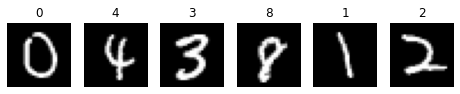

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 6, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainMNIST), size=(1,)).item()
    img, label = trainMNIST[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(str(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

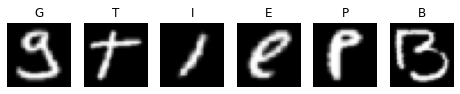

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 6, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainEMNIST), size=(1,)).item()
    img, label = trainEMNIST[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(chr(label+64))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
letters_train = []
letters_train2 = []

letters_test = []
letters_test2 = []

for img, label in trainEMNIST:
	if chr(label + 96) in trainEMNIST.classes[1:21] and len(letters_train) < 231 * 20:
		letters_train.append((img, 10))
	if chr(label + 96) in trainEMNIST.classes[21:] and len(letters_train2) < 230 * 6:
		letters_train2.append((img, 10))
	
for img, label in testEMNIST:
	if chr(label + 96) in testEMNIST.classes[1:21] and len(letters_test) < 38 * 20:
		letters_test.append((img, 10))
	if chr(label + 96) in testEMNIST.classes[21:] and len(letters_test2) < 40 * 6:
		letters_test2.append((img, 10))


In [7]:
letters_train.extend(letters_train2)
letters_test.extend(letters_test2)

In [8]:
print(len(letters_train))
print(len(letters_test))
print(type(letters_train[0][0]))
print(type(letters_train[0][1]))

6000
1000
<class 'torch.Tensor'>
<class 'int'>


In [9]:
numbers_train = [(img, label) for img, label in trainMNIST]
numbers_test = [(img, label) for img, label in testMNIST]

# numbers_train = [(img, F.one_hot(torch.tensor(label), num_classes=11)) for img, label in trainMNIST]
# numbers_test = [(img, F.one_hot(torch.tensor(label), num_classes=11)) for img, label in testMNIST]

<class 'torch.Tensor'>
<class 'int'>


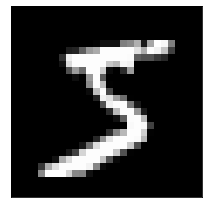

5


In [48]:
print(type(numbers_train[0][0]))
print(type(numbers_train[0][1]))
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3, 3),
                        subplot_kw={'xticks': [], 'yticks': []})


axs.imshow(numbers_train[0][0].squeeze(), cmap='gray')

plt.tight_layout()
plt.show()
print(numbers_train[0][1])

In [11]:
numbers_train.extend(letters_train)
numbers_test.extend(letters_test)

In [12]:
print(len(numbers_train))
print(len(numbers_test))

66000
11000


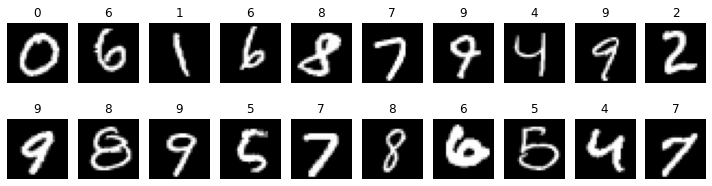

In [13]:
figure = plt.figure(figsize=(10, 3))
cols, rows = 10, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(numbers_train), size=(1,)).item()
    img, label = numbers_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    #plt.title(torch.argmax(label, dim=0))
    plt.title(str(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.tight_layout()
plt.show()

In [14]:
train = torch.utils.data.DataLoader(numbers_train, batch_size=2000, shuffle=True)
test = torch.utils.data.DataLoader(numbers_test, batch_size=2000, shuffle=False)

In [15]:
print(torch.cuda.device_count())
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
# device = torch.device("cpu")

1
Running on the GPU


In [16]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm32 = nn.BatchNorm2d(32)
        self.batchnorm64 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64*3*3, 64)
        self.fc2 = nn.Linear(64, 11)
        self.dropout = nn.Dropout(p = 0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm32(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm64(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64*3*3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm32): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=11, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [17]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

EPOCHS = 60
losses = np.zeros(EPOCHS)
acc = np.zeros(EPOCHS)

losses_test = np.zeros(EPOCHS)
acc_test = np.zeros(EPOCHS)

for epoch in range(EPOCHS):
    if epoch > EPOCHS * 3 / 4: optimizer = optim.Adam(net.parameters(), lr=0.0001)
    net.train() 
    correct = 0
    for data in train:
        x, y = data
        x, y = x.to(device), y.to(device)
        net.zero_grad()
        #output = net(x.view(-1,784))
        output = net(x)
        loss = loss_function(output, y)
        losses[epoch] = loss.item()
        loss.backward()
        optimizer.step()
        _, predictions = torch.max(output, 1)
        correct += (predictions == y).sum() / len(y)
    acc[epoch] = correct/len(train)
    #print(f"Epoch: {epoch}. [Train] Loss: {loss} Acc: {correct/len(train)}")
    net.eval()
    correct_test = 0
    for data in test:
        x, y = data
        x, y = x.to(device), y.to(device)
        output = net(x)
        loss_test = loss_function(output, y)
        _, predictions = torch.max(output, 1)
        correct_test += (predictions == y).sum() / len(y)
    losses_test[epoch] = loss_test
    acc_test[epoch] = correct_test / len(test)
    print(f"Epoch: {epoch}. [Train] Loss: {loss} Acc: {correct/len(train)} \t [Test] Loss: {loss_test} Acc: {correct_test/len(test)}")

C:\Users\mchuv\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0. [Train] Loss: 1.786388635635376 Acc: 0.5455605983734131 	 [Test] Loss: 2.5111899375915527 Acc: 0.7295834422111511
Epoch: 1. [Train] Loss: 1.7140026092529297 Acc: 0.8185456991195679 	 [Test] Loss: 2.524414539337158 Acc: 0.796583354473114
Epoch: 2. [Train] Loss: 1.662113904953003 Acc: 0.8609243035316467 	 [Test] Loss: 2.1291675567626953 Acc: 0.8827501535415649
Epoch: 3. [Train] Loss: 1.6195412874221802 Acc: 0.9097575545310974 	 [Test] Loss: 1.8261584043502808 Acc: 0.9272500276565552
Epoch: 4. [Train] Loss: 1.60289466381073 Acc: 0.9367728233337402 	 [Test] Loss: 1.7260801792144775 Acc: 0.9449167251586914
Epoch: 5. [Train] Loss: 1.5990153551101685 Acc: 0.9510455131530762 	 [Test] Loss: 1.5631883144378662 Acc: 0.9781667590141296
Epoch: 6. [Train] Loss: 1.5822962522506714 Acc: 0.9615303874015808 	 [Test] Loss: 1.561585545539856 Acc: 0.9820833206176758
Epoch: 7. [Train] Loss: 1.5806031227111816 Acc: 0.9657424688339233 	 [Test] Loss: 1.5639249086380005 Acc: 0.9813333749771118
Epoch: 

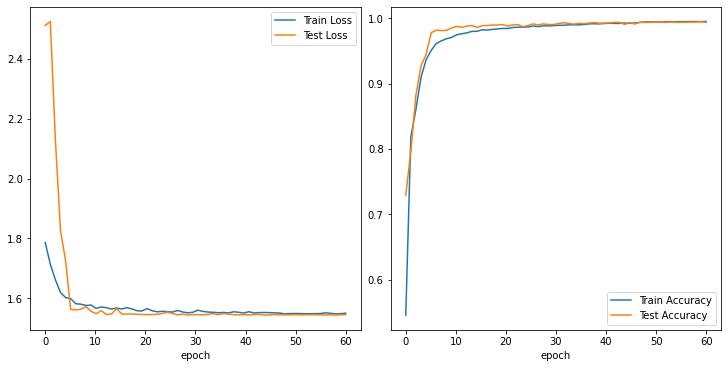

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10, 5))

axs[0].plot(np.linspace(0, EPOCHS, EPOCHS), losses, label='Train Loss')
axs[0].plot(np.linspace(0, EPOCHS, EPOCHS), losses_test, label='Test Loss')
axs[0].set_xlabel('epoch')
axs[0].legend()
axs[1].plot(np.linspace(0, EPOCHS, EPOCHS), acc, label='Train Accuracy')
axs[1].plot(np.linspace(0, EPOCHS, EPOCHS), acc_test, label='Test Accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend()
plt.show()

In [34]:
torch.save(net.state_dict(), 'model.pt')

In [35]:
model = Net().to(device)
model.load_state_dict(torch.load('model.pt'))


<All keys matched successfully>

In [36]:
correct = 0
y_pred = np.empty([0], dtype='int64')
model.eval()

with torch.no_grad():
    for data in test:
        x, y = data
        x, y = x.to(device), y.to(device)
        output = model(x)
        _, predictions = torch.max(output, 1)
        y_pred = np.concatenate((y_pred, predictions.cpu()))
        correct += (predictions == y).sum() / len(y)

#y_pred = np.array(y_pred, dtype=object)
print(y_pred.shape)
print(f'Acc: {correct/len(test)}')

(11000,)
Acc: 0.9941667914390564


In [37]:
correct_pred = [0] * 11
incorrect_pred = [0] * 11
total_pred = [0] * 11

with torch.no_grad():
    for data in test:
        x, y = data
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        #outputs = model(x.view(-1,784))
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(y, predictions):
            if label == prediction:
                correct_pred[label.item()] += 1
            else: incorrect_pred[label.item()] += 1
            total_pred[label.item()] += 1


for classname, correct_count in enumerate(correct_pred):
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class {classname} is: {accuracy}')

Accuracy for class 0 is: 99.59183673469387
Accuracy for class 1 is: 99.8237885462555
Accuracy for class 2 is: 99.6124031007752
Accuracy for class 3 is: 99.5049504950495
Accuracy for class 4 is: 98.98167006109979
Accuracy for class 5 is: 99.32735426008969
Accuracy for class 6 is: 98.95615866388309
Accuracy for class 7 is: 99.31906614785993
Accuracy for class 8 is: 99.38398357289527
Accuracy for class 9 is: 99.00891972249752
Accuracy for class 10 is: 99.7


In [38]:
print(np.array([i[1] for i in numbers_test])[-10:])
print(y_pred[-10:])
print(classification_report(np.array([i[1] for i in numbers_test]), y_pred, target_names=[str(el) for el in range(11)]))

[10 10 10 10 10 10 10 10 10 10]
[10 10 10 10 10 10 10 10 10 10]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       1.00      1.00      1.00      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      1.00       974
           9       0.99      0.99      0.99      1009
          10       1.00      1.00      1.00      1000

    accuracy                           0.99     11000
   macro avg       0.99      0.99      0.99     11000
weighted avg       0.99      0.99      0.99     11000



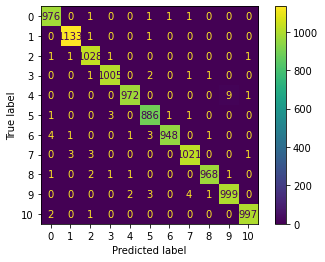

In [39]:
ConfusionMatrixDisplay.from_predictions(np.array([i[1] for i in numbers_test]), y_pred)
plt.show()

In [41]:
y_test = np.array([i[1] for i in numbers_test])
# выбираем правильно классифицированные и считаем количество встречающихся для каждого класса
tp = np.bincount(y_test[y_test == y_pred])
# считаем предствителей каждого класса в предсказанных
pred_sum = np.bincount(y_pred)
# считаем представителей каждого класса в тестовых
true_sum = np.bincount(y_test)
# print(true_sum)
fp = pred_sum - tp
fn = true_sum - tp
tn = y_test.shape[0] - tp - fp - fn
# print(tn, tp, fn, fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * tp / (2 * tp + fp + fn)
print('precision \t recall \t f1')
for i in range(11):
	print(f'{round(precision[i], 2)} \t\t {round(recall[i], 2)} \t\t {round(f1_score[i], 2)}')

precision 	 recall 	 f1
0.99 		 1.0 		 0.99
1.0 		 1.0 		 1.0
0.99 		 1.0 		 0.99
1.0 		 1.0 		 1.0
1.0 		 0.99 		 0.99
0.99 		 0.99 		 0.99
1.0 		 0.99 		 0.99
0.99 		 0.99 		 0.99
1.0 		 0.99 		 1.0
0.99 		 0.99 		 0.99
1.0 		 1.0 		 1.0


In [51]:
false_pred = [(i, el) for i, el in enumerate(numbers_test) if el[1] != y_pred[i]]
print(len(false_pred))

67


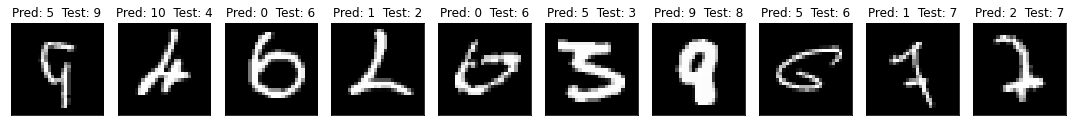

In [52]:
# Вывод 10 неверных результатов
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
    ax.imshow(false_pred[i][1][0].squeeze(), cmap='gray')
    ax.set_title('Pred: ' + str(y_pred[false_pred[i][0]]) + '  Test: ' + str(false_pred[i][1][1]))
plt.tight_layout()
plt.show()

In [44]:
incorrect_count = list(zip(range(11), incorrect_pred))
incorrect_count.sort(key = lambda r: (r[1]))
print(incorrect_count)

[(1, 2), (10, 3), (0, 4), (2, 4), (3, 5), (5, 6), (8, 6), (7, 7), (4, 10), (6, 10), (9, 10)]


In [45]:
for i in range(len(false_pred)):
	false_pred[i] += (incorrect_pred[false_pred[i][1][1]], )

false_pred.sort(key = lambda r:(r[2]))

for el in false_pred:
	print(f'Class number: {el[1][1]} \t Img idx: {el[0]} \t Incorrect in class: {el[2]}')

Class number: 1 	 Img idx: 2266 	 Incorrect in class: 2
Class number: 1 	 Img idx: 3073 	 Incorrect in class: 2
Class number: 10 	 Img idx: 10587 	 Incorrect in class: 3
Class number: 10 	 Img idx: 10901 	 Incorrect in class: 3
Class number: 10 	 Img idx: 10924 	 Incorrect in class: 3
Class number: 2 	 Img idx: 326 	 Incorrect in class: 4
Class number: 0 	 Img idx: 1621 	 Incorrect in class: 4
Class number: 0 	 Img idx: 2329 	 Incorrect in class: 4
Class number: 2 	 Img idx: 2462 	 Incorrect in class: 4
Class number: 2 	 Img idx: 3681 	 Incorrect in class: 4
Class number: 2 	 Img idx: 5449 	 Incorrect in class: 4
Class number: 0 	 Img idx: 6597 	 Incorrect in class: 4
Class number: 0 	 Img idx: 6651 	 Incorrect in class: 4
Class number: 3 	 Img idx: 449 	 Incorrect in class: 5
Class number: 3 	 Img idx: 1681 	 Incorrect in class: 5
Class number: 3 	 Img idx: 4443 	 Incorrect in class: 5
Class number: 3 	 Img idx: 4740 	 Incorrect in class: 5
Class number: 3 	 Img idx: 5955 	 Incorrect 

In [46]:
torch.cuda.empty_cache()

In [47]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

dump_tensors()

Tensor: GPU pinned 32
Tensor: GPU pinned 32
Tensor: GPU pinned 64
Tensor: GPU pinned 64
Parameter: GPU pinned 32 × 1 × 3 × 3
Parameter: GPU pinned 32
Parameter: GPU pinned 32
Parameter: GPU pinned 32
Parameter: GPU pinned 64
Parameter: GPU pinned 64
Parameter: GPU pinned 64 × 32 × 3 × 3
Parameter: GPU pinned 64
Parameter: GPU pinned 64 × 64 × 3 × 3
Parameter: GPU pinned 64
Parameter: GPU pinned 64 × 576
Parameter: GPU pinned 64
Parameter: GPU pinned 11 × 64
Parameter: GPU pinned 11
Tensor: GPU pinned 32 × 1 × 3 × 3
Tensor: GPU pinned 32
Tensor: GPU pinned 32
Tensor: GPU pinned 32
Tensor: GPU pinned 64
Tensor: GPU pinned 64
Tensor: GPU pinned 64 × 32 × 3 × 3
Tensor: GPU pinned 64
Tensor: GPU pinned 64 × 64 × 3 × 3
Tensor: GPU pinned 64
Tensor: GPU pinned 64 × 576
Tensor: GPU pinned 64
Tensor: GPU pinned 11 × 64
Tensor: GPU pinned 11
Tensor: GPU pinned 32 × 1 × 3 × 3
Tensor: GPU pinned 32
Tensor: GPU pinned 32
Tensor: GPU pinned 32
Tensor: GPU pinned 64
Tensor: GPU pinned 64
Tensor: GPU 

C:\Users\mchuv\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\distributed\distributed_c10d.py:151: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "
